### Read from DB ###

In [1]:
import sqlalchemy as sql
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
engine=sql.create_engine('sqlite:///bnb_crypto_price_db.db')

In [3]:
engine.table_names()

['bnb_cypto_price']

In [4]:
df=pd.read_sql_table('bnb_cypto_price', con=engine, index_col='Date', parse_dates=True)
df=df.drop(columns='index')
df.head()

,Close,Volume,Ticker
Date,,,
2017-11-09,1.99077,19192200,BNB
2017-11-10,1.79684,11155000,BNB
2017-11-11,1.67047,8178150,BNB
2017-11-12,1.51969,15298700,BNB
2017-11-13,1.68662,12238800,BNB


In [5]:
df.index

DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2022-07-28', '2022-07-29', '2022-07-30', '2022-07-31',
               '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-06'],
              dtype='datetime64[ns]', name='Date', length=1732, freq=None)

<AxesSubplot:xlabel='Date'>

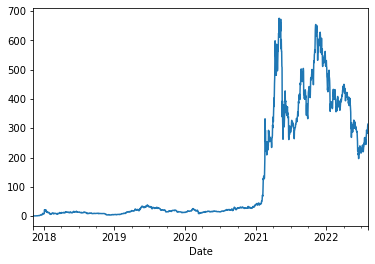

In [6]:
df['Close'].plot()

### ML ###

create a table like below: 
<img src='./images/sample_features.png' width=720>

In [7]:
features=df[['Close']]
window_size=5
for i in range(1, window_size+1): 
    features[f'Close T-{i}']=features['Close'].shift(i)

features=features.dropna()
features.head()

,Close,Close T-1,Close T-2,Close T-3,Close T-4,Close T-5
Date,,,,,,
2017-11-14,1.59258,1.68662,1.51969,1.67047,1.79684,1.99077
2017-11-15,1.53045,1.59258,1.68662,1.51969,1.67047,1.79684
2017-11-16,1.57792,1.53045,1.59258,1.68662,1.51969,1.67047
2017-11-17,1.51036,1.57792,1.53045,1.59258,1.68662,1.51969
2017-11-18,1.67433,1.51036,1.57792,1.53045,1.59258,1.68662


In [8]:
y=features[['Close']]
X=features.drop(columns=['Close'])

Split into training and testing

In [18]:
# split at 2021 / 9
X_train=X.loc[:'2021-09']
y_train=y.loc[:'2021-09']
X_test=X.loc['2021-10':]
y_test=y.loc['2021-10':]

In [19]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(1417, 5)

(310, 5)

(1417, 1)

(310, 1)

### Scale Data ###

In [20]:
from sklearn.preprocessing import MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X_train)
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

In [21]:
y_scaler=MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled=y_scaler.transform(y_train)
y_test_scaled=y_scaler.transform(y_test)

### Reshape ###

In [22]:
X_train_scaled=X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_scaled=X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

### Build Model ###

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [24]:
model=Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dense(units=1, activation='linear'))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 30)             3840      
                                                                 
 dropout_2 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 30)             7320      
                                                                 
 dropout_3 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [26]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [27]:
model.fit(X_train_scaled, y_train_scaled, epochs=50)

Epoch 1/50
45/45 [==============================] - 3s 7ms/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 9.0410e-04 - mean_squared_error: 9.0410e-04
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 8.6427e-04 - mean_squared_error: 8.6427e-04
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 7.8177e-04 - mean_squared_error: 7.8177e-04
Epoch 6/50
45/45 [==============================] - 0s 6ms/step - loss: 8.3926e-04 - mean_squared_error: 8.3926e-04
Epoch 7/50
45/45 [==============================] - 0s 6ms/step - loss: 8.3667e-04 - mean_squared_error: 8.3667e-04
Epoch 8/50
45/45 [==============================] - 0s 5ms/step - loss: 8.0436e-04 - mean_squared_error: 8.0436e-04
Epoch 9/50
45/45 [==============================] - 0s 5ms/step - loss: 6.5475e-04 - mea

In [28]:
y_predicted=model.predict(X_test_scaled)

10/10 [==============================] - 1s 3ms/step


### Plot Prediction ###

In [29]:
import matplotlib.pyplot as plt

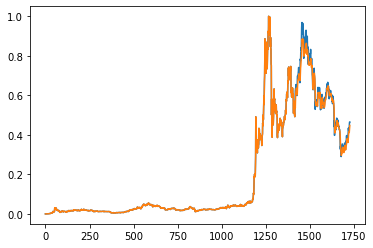

In [30]:
price=np.concatenate([y_train_scaled.ravel(), y_test_scaled.ravel()])
prediction=np.concatenate([y_train_scaled.ravel(), y_predicted.ravel()])
fig=plt.figure()
plt.plot(price)
plt.plot(prediction)

In [31]:
next_prediction_input=df.iloc[-5:]['Close'].values
next_prediction_input_scaled=X_scaler.transform([next_prediction_input])

In [32]:
next_prediction_input_scaled

array([[0.41875056, 0.44031147, 0.45862911, 0.46527353, 0.46510052]])

In [33]:
next_prediction=model.predict([next_prediction_input_scaled])
next_prediction

1/1 [==============================] - 1s 852ms/step


array([[0.42961913]], dtype=float32)

In [34]:
y_scaler.inverse_transform(next_prediction)

array([[291.1483]], dtype=float32)